In [1]:
#!pip install grad-cam

In [2]:
import sys
import os

import torch
import os
import numpy as np
from torchvision import transforms
from pytorch_grad_cam import GradCAM, ScoreCAM, AblationCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.transforms import functional as F
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
from DatasetLoader.cub_v2 import cub200
import CNN.resnet50 as rn50


MODEL_SAVE_PATH = './CNN/model_save'
DATASET_ROOT = 'CUB/DATASET/'
DATASET_IMAGES = os.path.join(DATASET_ROOT, "CUB_200_2011")

GAZE_MAP_DIR = 'CUB/GAZE_DATASET/CUB_GHA'

DEFAULT_BATCH_SIZE   = 1
DEFAULT_BASE_LR      = 0.001
DEFAULT_EPOCHS       = 95
DEFAULT_MOMENTUM     = 0.9
DEFAULT_WEIGHT_DECAY = 1e-4
DEFAULT_GPU_ID       = 0
DEFAULT_IMG_SIZE     = 448 #448 previously

MODEL_CHOICES        = [50, 101, 152]

options = {
    'net_choice': "ResNet",
    'model_choice': MODEL_CHOICES[0],
    'epochs': DEFAULT_EPOCHS,
    'batch_size': DEFAULT_BATCH_SIZE,
    'base_lr': DEFAULT_BASE_LR,
    'weight_decay': DEFAULT_WEIGHT_DECAY,
    'momentum': DEFAULT_MOMENTUM,
    'img_size': DEFAULT_IMG_SIZE,
    'device': torch.device('cuda:'+str(DEFAULT_GPU_ID) if torch.cuda.is_available() else 'cpu')
}

path = {
    'data': DATASET_ROOT,
    'model_save': MODEL_SAVE_PATH
}


In [3]:
def print_gpu_memory_usage(stage=""):
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / (1024**3) # Convert bytes to GiB
        reserved = torch.cuda.memory_reserved() / (1024**3)   # Convert bytes to GiB
        print(f"--- GPU Memory Usage ({stage}) ---")
        print(f"Allocated: {allocated:.2f} GiB")
        print(f"Reserved: {reserved:.2f} GiB")
        # Note: 'free' is not directly exposed as easily as allocated/reserved by PyTorch
        # The total_memory - allocated - cached is a rough estimate
        total_memory = torch.cuda.get_device_properties(0).total_memory / (1024**3)
        print(f"Total GPU Memory: {total_memory:.2f} GiB")
        print(f"Estimated Free: {total_memory - allocated:.2f} GiB (rough estimate)")
        print("-----------------------------------")
    else:
        print("CUDA not available.")


In [4]:
def pad_to_square(img, fill=0):
    # img: PIL Image
    w, h = img.size
    if w == h:
        return img
    if w < h:
        diff = h - w
        left = diff // 2
        right = diff - left
        top = bottom = 0
    else:
        diff = w - h
        top = diff // 2
        bottom = diff - top
        left = right = 0
    # padding = (left, top, right, bottom)
    return F.pad(img, (left, top, right, bottom), fill=fill, padding_mode='constant')


In [5]:

# ---- MODEL SETUP ----
model = rn50.load_resnet50_checkpoint(checkpoint_path=os.path.join(MODEL_SAVE_PATH, 'ResNet', 'ResNet50.pkl'), pre_trained=True, n_class=200, model_choice=50)

model.to(options['device'])
model.eval()

print(model)

#score_cam = rn50.wrap_resnet50_cam(model, ScoreCAM)
# Wrap the model with AblationCAM
#ablation_cam = rn50.wrap_resnet50_cam(model, AblationCAM)

grad_cams = {
    'GradCAM': rn50.wrap_resnet50_cam(model, GradCAM),
    'ScoreCAM': rn50.wrap_resnet50_cam(model, ScoreCAM),
    'AblationCAM': rn50.wrap_resnet50_cam(model, AblationCAM)
}

print(next(model.parameters()).device)

/home/matteo/miniforge3/envs/Resnet/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/matteo/miniforge3/envs/Resnet/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


=> loading checkpoint './CNN/model_save/ResNet/ResNet50.pkl'
=> loading checkpoint './CNN/model_save/ResNet/ResNet50.pkl'
ResNet(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum

In [6]:
transform_list = [
    transforms.Lambda(lambda img: pad_to_square(img)),
    transforms.Resize(int(options['img_size'])),
    #transforms.CenterCrop(options['img_size']),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406),
                         std=(0.229, 0.224, 0.225))
]

#train_data = cub200(path['data'], train=True, transform=transforms.Compose(transform_list))
test_data = cub200(path['data'], train=False, transform=transforms.Compose(transform_list))

#train_loader = torch.utils.data.DataLoader(
#    train_data, batch_size=options['batch_size'], shuffle=True, num_workers=4, pin_memory=torch.cuda.is_available()
#)
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=options['batch_size'], shuffle=False, num_workers=4, pin_memory=torch.cuda.is_available()
)


Test file has been extracted


                                                   Image  Label  Train
ID                                                                    
1      001.Black_footed_Albatross/Black_Footed_Albatr...      0      0
3      001.Black_footed_Albatross/Black_Footed_Albatr...      0      0
6      001.Black_footed_Albatross/Black_Footed_Albatr...      0      0
10     001.Black_footed_Albatross/Black_Footed_Albatr...      0      0
12     001.Black_footed_Albatross/Black_Footed_Albatr...      0      0
...                                                  ...    ...    ...
11780  200.Common_Yellowthroat/Common_Yellowthroat_00...    199      0
11783  200.Common_Yellowthroat/Common_Yellowthroat_00...    199      0
11785  200.Common_Yellowthroat/Common_Yellowthroat_00...    199      0
11786  200.Common_Yellowthroat/Common_Yellowthroat_00...    199      0
11788  200.Common_Yellowthroat/Common_Yellowthroat_00...    199      0

[5794 rows x 3 columns]
[1, 3, 6, 10, 12, 13, 14, 16, 17, 19, 22, 24, 25, 26

100%|██████████| 64/64 [00:05<00:00, 11.04it/s]


--- GPU Memory Usage (AFTER GRAD-CAM INFERENCE) ---
Allocated: 1.21 GiB
Reserved: 10.07 GiB
Total GPU Memory: 15.55 GiB
Estimated Free: 14.33 GiB (rough estimate)
-----------------------------------
Processing Image ID: 1, Gaze Map Path: CUB/GAZE_DATASET/CUB_GHA/1.jpg


error: OpenCV(4.12.0) /io/opencv/modules/imgproc/src/colormap.cpp:736: error: (-5:Bad argument) cv::ColorMap only supports source images of type CV_8UC1 or CV_8UC3 in function 'operator()'


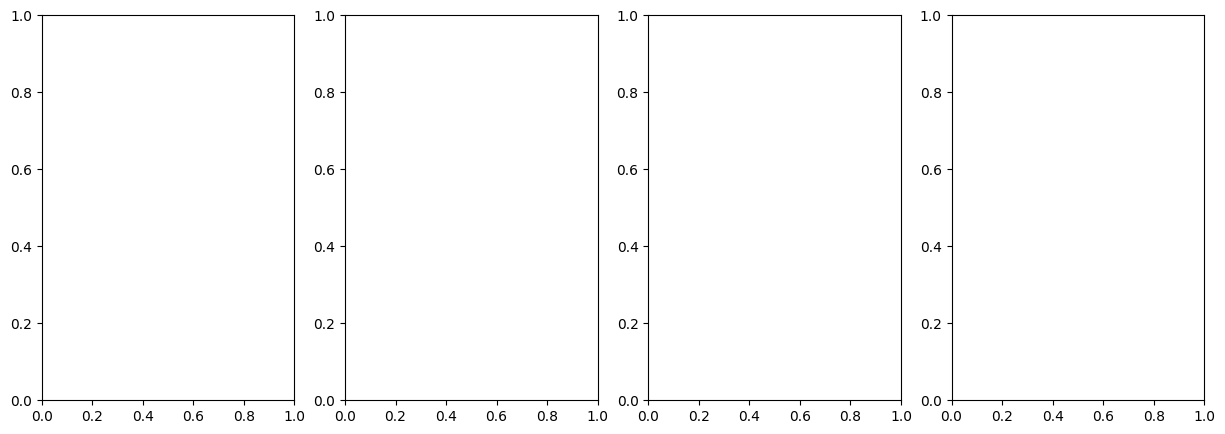

In [ ]:
df_img = pd.read_csv(os.path.join(DATASET_IMAGES, 'images.txt'), sep=' ', header=None, names=['ID', 'Image'], index_col=0)
df_label = pd.read_csv(os.path.join(DATASET_IMAGES, 'image_class_labels.txt'), sep=' ', header=None, names=['ID', 'Label'], index_col=0)
df_split = pd.read_csv(os.path.join(DATASET_IMAGES, 'train_test_split.txt'), sep=' ', header=None, names=['ID', 'Train'], index_col=0)
df = pd.concat([df_img, df_label, df_split], axis=1)
# relabel
df['Label'] = df['Label'] - 1

#take only test set
df_test = df[df['Train']==0]
df_test_indices = df_test.index.to_list()

print_gpu_memory_usage("BEFORE INFERENCE")

for images, labels, image_indices in test_loader:
    torch.cuda.empty_cache()

    images = images.to(options['device'])
    #labels = labels.to(options['device'])
    batch_cam_images = {cam_name: [] for cam_name in grad_cams.keys()}
    print_gpu_memory_usage("AFTER LOADING BATCH")
    # ---- GRAD-CAM ----
    targets = [ClassifierOutputTarget(label.item()) for label in labels]

    cam_images = {}
    for cam_name, cam in grad_cams.items():
        grayscale_cam_batch = cam(input_tensor=images, targets=targets)
        batch_cam_images[cam_name].extend(grayscale_cam_batch)
    print_gpu_memory_usage("AFTER GRAD-CAM INFERENCE")

    for i in range(images.shape[0]):
        current_image_idx_in_dataset = df_test_indices[image_indices[i]]
        target_class = labels[i].item()

        # ---- CONVERT IMAGE TO RGB (0-1) for visualization ----
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        rgb_img = images[i].permute(1, 2, 0).cpu().numpy()
        rgb_img = std * rgb_img + mean
        rgb_img = np.clip(rgb_img, 0, 1)

        # ---- GAZE MAP ----
        gaze_map_path = os.path.join(GAZE_MAP_DIR, "{}.jpg".format(current_image_idx_in_dataset))

        print(f"Processing Image ID: {current_image_idx_in_dataset}, Gaze Map Path: {gaze_map_path}")

        if not os.path.exists(gaze_map_path):
            print(f"Gaze Map File not found, skipping: {gaze_map_path}")
            continue

        gt_img = Image.open(gaze_map_path).convert("L")
        gt_img = pad_to_square(gt_img)
        gt_img = gt_img.resize((options['img_size'], options['img_size']))
        gt_img = np.array(gt_img).astype(np.float32)

        # ---- VISUALIZATION ----
        f, ax = plt.subplots(1, len(grad_cams) + 1, figsize=(15, 5))
        visualization = show_cam_on_image(rgb_img, gt_img, use_rgb=True, image_weight=0.5)
        ax[0].imshow(visualization)
        ax[0].set_title("Ground Truth Gaze Map")
        ax[0].axis('off')
        for j, (cam_name, cam_output_list) in enumerate(batch_cam_images.items()):
            # Get the specific CAM image for the current image in the batch
            cam_img = cam_output_list[i]
            visualization = show_cam_on_image(rgb_img, cam_img, use_rgb=True, image_weight=0.5)
            ax[j+1].imshow(visualization, cmap='gray')
            ax[j+1].set_title(f"{cam_name}")
            ax[j+1].axis('off')
        plt.show()
        plt.close(f)
